In [353]:
# %matplotlib nbagg
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
from glob import glob

from ase.io import lammpsdata, read
import os

x_width = round(5.43 * 7.5, 2)
y_width = round(5.43 * 7.5, 2)
z_width = round(5.43 * 15.0, 2)
upper_limit = 5.43 * 17.5
# ni_lattice_constant = 2.316
# x_width = round(ni_lattice_constant * 15, 2)
# y_width = round(ni_lattice_constant * 15, 2)
# z_width = round(ni_lattice_constant * 30, 2)
# upper_limit = ni_lattice_constant * 35.0
ang3tocm3 = 1.0e24

In [354]:
path2data = '/Users/y1u0d2/desktop/Lab/result/lammps/Si/sputtering/ml/atom6750/model07/0deg_100eV'
# path2data = '/Users/y1u0d2/desktop/Lab/result/lammps/Ni/Ni_self'
pathes = glob(f'{path2data}/data.Si.*')
pathes.sort()
print(len(pathes))

372


In [355]:
path = pathes[0]
structure = lammpsdata.read_lammps_data(file=path, style='atomic')
structure.get_number_of_atoms()

/Users/y1u0d2/opt/anaconda3/envs/ml/lib/python3.10/site-packages/ase/atoms.py:967: VisibleDeprecationWarning: Use get_global_number_of_atoms() instead
  warnings.warn('Use get_global_number_of_atoms() instead',


6750

In [356]:
position_df = pd.DataFrame(data=structure.positions, columns=['x', 'y', 'z'])

In [357]:
position_df.head()

,x,y,z
0,0.00543,0.00543,0.00543
1,0.00543,2.72043,2.72043
2,2.72043,0.00543,2.72043
3,2.72043,2.72043,0.00543
4,1.36293,1.36293,1.36293


<AxesSubplot:xlabel='x', ylabel='z'>

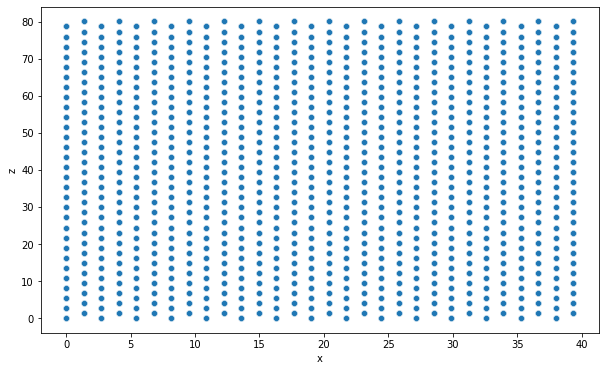

In [358]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

sns.scatterplot(data=position_df, x='x', y='z', ax=ax)

In [359]:
z_position = position_df['z'].values
z_position = np.sort(z_position)

# convert coordinate to depth
depth = z_position - z_width
depth = np.sort(depth)

In [360]:
width = 3
linspace = np.linspace(3, -z_width, 100)
n_atom_list = []
for i in linspace:
    n_atom_in_range = ((i - width/2 < depth) & (depth < i + width/2)).sum()
    vol = x_width * y_width * width
    # density = n_atom_in_range / vol * ang3tocm3 # ang^-3
    density = n_atom_in_range / vol # ang^-3
    n_atom_list.append(density)

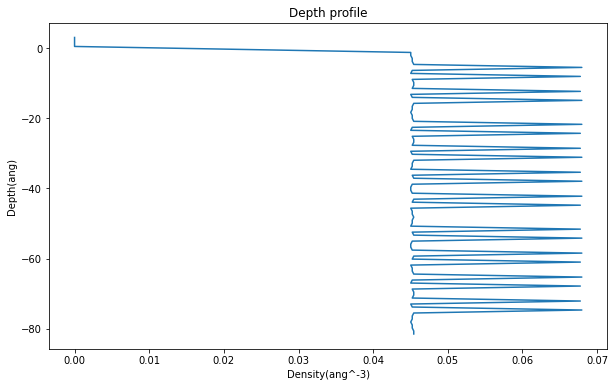

In [361]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

ax.set_title('Depth profile')
ax.set_xlabel('Density(ang^-3)')
ax.set_ylabel('Depth(ang)')
ax.plot(n_atom_list, linspace)

In [365]:
def get_depth_profile(path2dumpfile):
    structure = lammpsdata.read_lammps_data(file=path2dumpfile, style='atomic')
    position_df = pd.DataFrame(data=structure.positions, columns=['x', 'y', 'z'])
    z_position = position_df['z'].values
    # z_position = np.sort(z_position)

    # convert z-position to depth
    depth = z_position - z_width
    # depth = np.sort(depth)

    n_space = 200
    step = 0.5
    moving_average_with_depth_interval = 3
    upper = step * n_space - z_width
    linspace = np.linspace(upper, -z_width, n_space + 1)
    
    width = step
    density_list = []
    for i in linspace:
        n_atom_in_range = ((i - width/2 < depth) & (depth < i + width/2)).sum()
        vol = x_width * y_width * width
        density = n_atom_in_range / vol * ang3tocm3 # cm^-3
        # density = n_atom_in_range / vol # ang^-3
        density_list.append(density)
    
    df = pd.DataFrame(data=np.stack([linspace, density_list]).T, columns=['linspace', 'density'])
    df['ma'] = df['density'].rolling(int(moving_average_with_depth_interval / step + 1), center=True).mean()
    df.dropna(axis=0, inplace=True)

    return df
    
from analyze.lmp.get_depth_profile import get_depth_profile

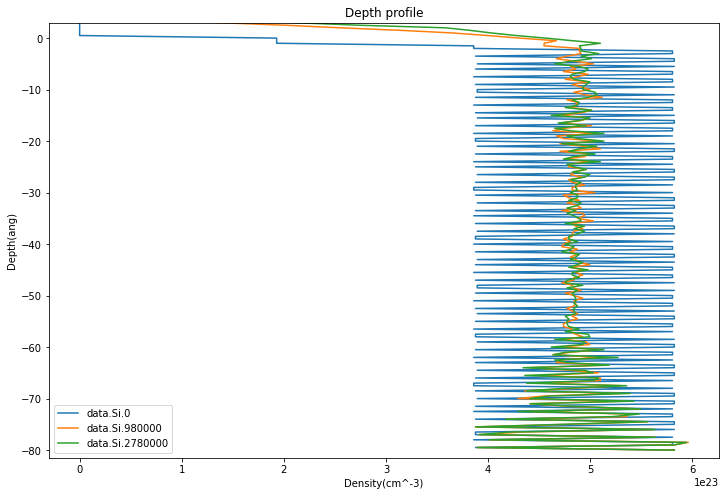

In [366]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

ax.set_title('Depth profile')
ax.set_xlabel('Density(cm^-3)')
ax.set_ylabel('Depth(ang)')
ax.set_ylim(-z_width, 3)

df = get_depth_profile(pathes[0], x_width=x_width, y_width=y_width, z_width=z_width)
ax.plot(df['ma'], df['linspace'],  label=pathes[0].split('/')[-1])

df = get_depth_profile(pathes[-1], x_width=x_width, y_width=y_width, z_width=z_width)
ax.plot(df['ma'], df['linspace'],  label=pathes[-1].split('/')[-1])

df = get_depth_profile(pathes[100], x_width=x_width, y_width=y_width, z_width=z_width)
ax.plot(df['ma'], df['linspace'],  label=pathes[100].split('/')[-1])

ax.legend()

In [364]:
df

,linspace,density,ma
3,17.05,0.000000e+00,0.000000e+00
4,16.55,0.000000e+00,0.000000e+00
5,16.05,0.000000e+00,0.000000e+00
6,15.55,0.000000e+00,0.000000e+00
7,15.05,0.000000e+00,0.000000e+00
...,...,...,...
193,-77.95,1.206186e+21,4.014878e+22
194,-78.45,0.000000e+00,5.944776e+22
195,-78.95,1.350929e+23,5.824158e+22
196,-79.45,0.000000e+00,3.894259e+22
